In [1]:
file_path = '/Users/lfinkbeiner/Documents/GitHub/HERA/beam/'
beam_origin = 'HERA_4.9m_E-pattern_151MHz.txt'
beam_destination = 'ant1_s2'

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
from RIMEz import beam_models
import numpy as np
import healpy as hp
from spin1_beam_model import cst_processing, jones_matrix_field

In [3]:
processor = cst_processing.CSTDataProcessor(
    [file_path + beam_origin,
    file_path + beam_origin,
    file_path + beam_origin],
    np.array([150e6, 151e6, 152e6]),
    1, 1e-4
)

In [4]:
processor.compute_spin1_harmonics()
processor.write_model_data(file_path, beam_destination)
spline_beam_func = beam_models.model_data_to_spline_beam_func(file_path + beam_destination + '.h5', np.array([150e6, 151e6, 152e6]))

//anaconda3/envs/hera/lib/python3.7/site-packages/spin1_beam_model/jones_matrix_field.py:18: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.pos1_Elm_samples = h5f["pos1_Elm"].value
//anaconda3/envs/hera/lib/python3.7/site-packages/spin1_beam_model/jones_matrix_field.py:19: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.neg1_Elm_samples = h5f["neg1_Elm"].value
//anaconda3/envs/hera/lib/python3.7/site-packages/spin1_beam_model/jones_matrix_field.py:20: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.freq_nodes = h5f["frequencies"].value
//anaconda3/envs/hera/lib/python3.7/site-packages/spin1_beam_model/jones_matrix_field.py:21: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.L_model = h5f["spatial_bandlimit"].value
//anaconda3/envs/hera/lib/python3.7/site-packages/spin1_beam_model/jones_matrix_field.py:22: H5pyDeprec

delta_nu_in is 1000000.0


In [5]:
import healpy as hp
#nside = 16, 32, 64, 128...
nside = 128

# healpix does the interpolation for you?
theta, phi = hp.pix2ang(nside,np.arange(12 * nside * nside))
az = phi
alt = np.pi / 2 - theta
J = spline_beam_func(150e6, alt, az)

In [6]:
# Current labels
# 0, 0 : xy
# 1, 0 : xx
# 0, 1 : yy
# 1, 1 : yx

J_abs = np.abs(J)

In [7]:
import rotations

In [65]:
print('HERA latitude:', rotations.hera_lat)
print('HERA longitude:', rotations.hera_lon)
print('Current LST:', rotations.get_lst())

HERA latitude: -30.72138888888889
HERA longitude: 21.428333333333335
Current LST: 5.594610082236582


In [12]:
el, be = rotations.eq_to_gal(rotations.hera_lat, rotations.hera_lon)
print('With right ascension = HERA latitude and declination = HERA longitude, we have:')
print('Galactic longitude:', el, 'Galactic latitude:', be)

With right ascension = HERA latitude and declination = HERA longitude, we have:
Galactic longitude: 77.522971004297 Galactic latitude: -25.693447620731042


In [75]:
def rad_interp(J_section, el, be):
    '''
    Abbreviation and conversion function. We get the interpolation value
    assuming @al and @be are in degrees.
    '''
    colatitude = np.radians(90 - el)
    longitude = np.radians(be)
    return hp.get_interp_val(J_section, colatitude, longitude)

def deg_interp(J_section, lon, lat):
    ''' This sucks. Don\'t use it.'''
    return hp.get_interp_val(J_section, lon, lat, lonlat=True)

In [76]:
el_ha, be_ha = rotations.ha_to_gal(rotations.get_lst(), rotations.hera_lon, rotations.get_lst(), radians=False)
print("Galactic longitude from hour-angle:", el_ha)
print("Galactic latitude from declination:", be_ha)
print("Naive interpolation (i.e. DON\'T DO THIS):", rad_interp(J_abs[:, 1, 0], el_ha, be_ha))

Galactic longitude from hour-angle: 107.2705601790137
Galactic latitude from declination: -39.87396162425974
Naive interpolation (i.e. DON'T DO THIS): 0.06052822843513114


In [77]:
# These should all be representations of the same quantity, an input very close to yielding the max. output
print(hp.get_interp_val(J_abs[:, 1, 0], 40, 90, lonlat=True))
print(hp.get_interp_val(J_abs[:, 1, 0], 0, np.radians(40), lonlat=False))
print(rad_interp(J_abs[:, 1, 0], 90, 40))
#print(interp(J_abs[:, 1, 0], 0, 0))

0.9981647450856114
0.9981647450856114
0.9981647450856114


In [79]:
# I am running out of patience here. Let us try to reverse-engineer our expectations, like bad scientists do.
colatitude_range = np.radians(np.linspace(0, 180, 20))
longitude_range = np.radians(np.linspace(-180, 180, 40))
# Yes, we are only doing 20 x 40 points. This thing EATS CPU!
def maximize(J_section):
    current_max = [0, 0, 0] # this is bad practice but we already know the maximum is greater than one
    for col in colatitude_range:
        for lon in longitude_range:
            ev = hp.get_interp_val(J_section, col, lon)
            if ev > current_max[0]:
                current_max[0] = ev
                current_max[1] = col
                current_max[2] = lon
    return current_max
# Of course, this approach will not be very helpful anyway because the maximum might span an area...

In [67]:
print(maximize(J_abs[:, 1, 0]))
# Failure!! How did that even happen?
print(maximize(J_abs[:, 0, 0]))

[0.9981647450856115, 0.0, -3.141592653589793]
[0.05959529562036919, 0.16534698176788384, -0.8860902356278905]


In [91]:
# :: xy and yx are just leakage terms; they are not beam response terms
# in other words, the maximum response can occur at any point, and it is okay that these do not maximize.

print(rad_interp(J_abs[:, 1, 0], 90, be_ha)) # true maximum: .998166
print(rad_interp(J_abs[:, 0, 0], 90, be_ha)) # ": .0624716
print(rad_interp(J_abs[:, 0, 1], 90, be_ha)) # ": .998166
print(rad_interp(J_abs[:, 1, 1], 90, be_ha)) # ": .0624716

0.9981647450856114
0.0026768872266952726
0.9981647531755684
0.002677818315750198


In [93]:
col_neigh = np.linspace(70, 110, 1000)
col_const = np.full(1000, 90)

lon_neigh = np.linspace(be_ha - 20, be_ha + 20, 1000)
lon_const = np.full(1000, be_ha)

In [121]:
def frame():
    '''
    Set up generic infrastructure for an improved-looking plot.
    We return the figure and the axis on which we want to plot.
    '''
    fig = plt.figure(figsize = (6, 3))

    plt.subplots_adjust(left=.15, bottom=.15, right=.95, top=.9)
    ax = fig.add_subplot(111)
    
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)

    return fig, ax

In [166]:
def response_plot(label, section):
    fig, ax = frame()
    plt.title(label + ' varying longitude about dec conversion')
    ax.plot(lon_neigh, rad_interp(section, col_const, lon_neigh))
    plt.ylabel('Response [0, 1]', fontsize=12)
    plt.xlabel('Longitude [$^\circ$]')
    plt.ylim(.99816, .99818) # for some awful reason this plot refuses to autozoom y
    plt.show()
    
    fig, ax = frame()
    plt.title(label + ' varying latitude about LST')
    ax.plot(col_neigh, rad_interp(section, col_neigh, lon_const))
    plt.ylabel('Response [0, 1]', fontsize=12)
    plt.xlabel('Latitude Not Colatitude [$^\circ$]')
    plt.show()

<IPython.core.display.Javascript object>


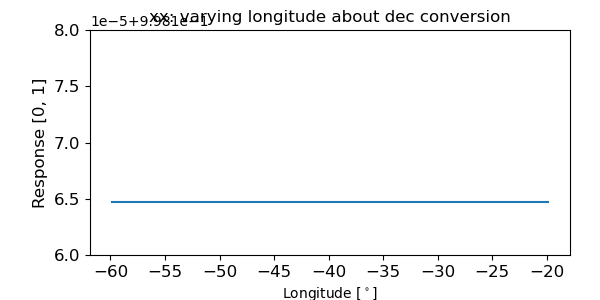

<IPython.core.display.Javascript object>


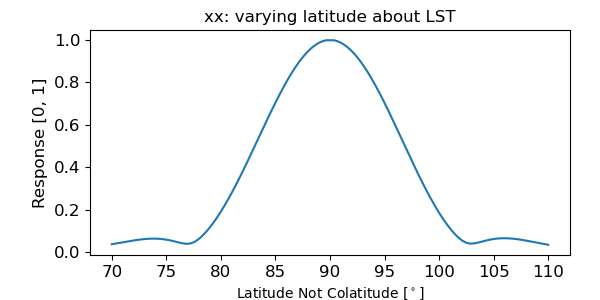

' I need to change x-axis label since we are not using galactic. Also, the scale should be changed to\n    get rid of that awful 1e-5+9.981e. Use (az, alt) instead of (alt, az).'

In [167]:
# We need to fix all labels:
    # we are not using galactic latitude and longitude anymore, we are using azimuth and altitude

# This plot shows that longitude has virtually no impact
response_plot('xx:', J_abs[:, 1, 0])
''' I need to change x-axis label since we are not using galactic. Also, the scale should be changed to
    get rid of that awful 1e-5+9.981e. Use (az, alt) instead of (alt, az).'''

<IPython.core.display.Javascript object>


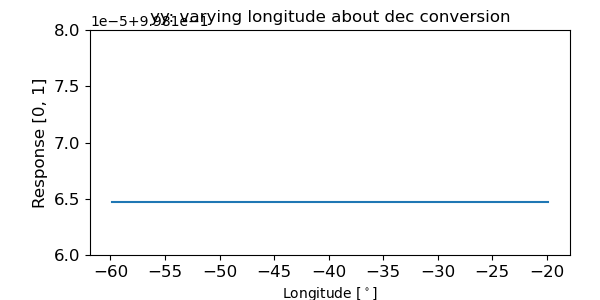

<IPython.core.display.Javascript object>


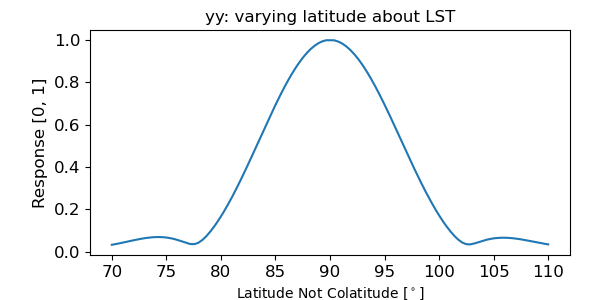

In [168]:
# These plots look pretty much identical to the xx
response_plot('yy:', J_abs[:, 0, 1])

<IPython.core.display.Javascript object>


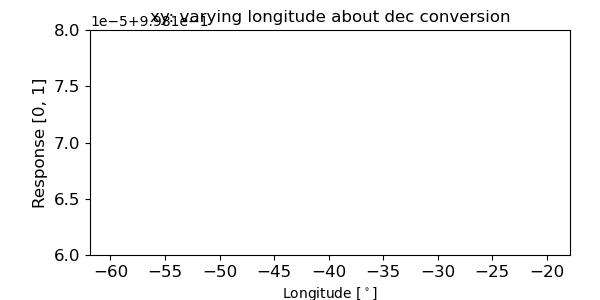

<IPython.core.display.Javascript object>


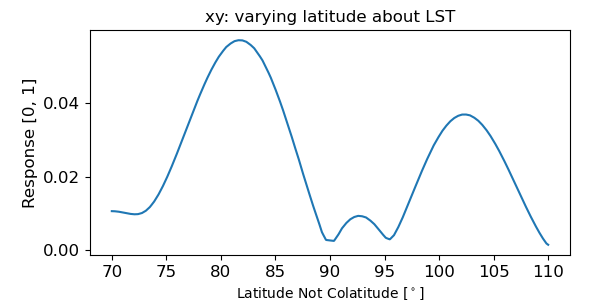

In [169]:
# ...
response_plot('xy:', J_abs[:, 0, 0])

<IPython.core.display.Javascript object>


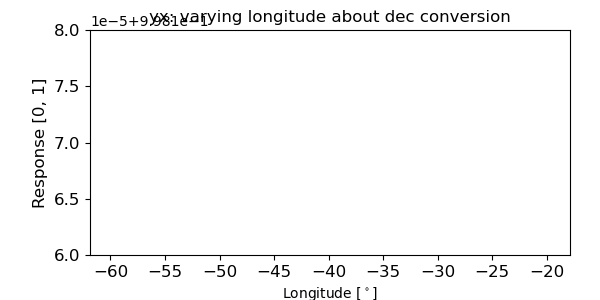

<IPython.core.display.Javascript object>


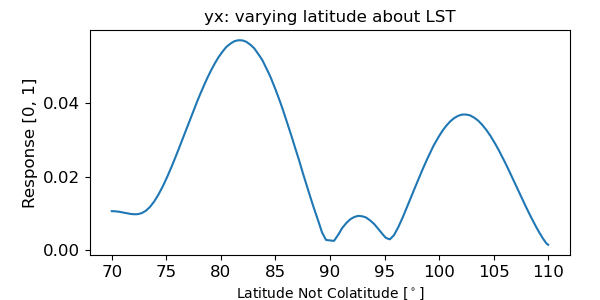

In [170]:
# ...
response_plot('yx:', J_abs[:, 0, 0])

In [ ]:
# Next step: we need to get conversion ironed-out because we want to plug sources into our project

# We need a rock-solid (azimuth, altitude) <- (right ascension, declination)